<a href="https://colab.research.google.com/github/dgromann/SemComp_WS2018/blob/master/Tutorial8_model_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Lesson 0.0.0: Store this notebook! 

Go to "File" and make sure you store this file as a local copy to either GitHub or your Google Drive. If you do not have a Google account and also do not want to create one, please check Option C below. 

Option A) Google Drive WITH collaboration

If you want to work in a collaborative manner where each of you in the group can see each other's contributions, one of you needs to store the notebook in Google Drive and share it with the others. You share it by clicking on the SHARE button on the top right of this page and share the link with the "everyone who receives this link can edit" option with the other team members per e-mail, skype, or any other way you prefer.

If you work with others, keep in mind to always copy the code before you edit it and always indicate your name as a comment (e.g. #Dagmar ) in the cell that it is clear who wrote which part. I also recommend creating a new code cell for your contributions.

Option B) Github without collaboration

Collaborative functions are not available when storing the notebook in GitHub; you will see your own work but not that of others.


Option C) Download this notebook as ipynb (Jupyter notebook) or py (Python file)

To run either of these on your local machine requires the installation of the required programs, which for the first tutorial are Python and NLTK. This will become more as we continue on to machine learning (requiring sklearn) and deep learning (requiring tensorflow and/or pytorch). In Google Codelab all of these are provided and do not need to be installed locally.


# Lesson 1.0: Text generation with LSTMs

Let's generate our first simple text generation model. 

## Data proprocessing

We will load all required software libraries and data and then preprocess the data. This includes generating a batch generator.

In [18]:
# Get data and required software packages

!wget https://raw.githubusercontent.com/dgromann/SemanticComputing/master/tutorial8/trump_tweets.txt
!pip3 install torch

import random
import math
import unidecode
import string
import re
import time

import torch
import torch.nn as nn
from torch.autograd import Variable

--2019-01-31 06:53:00--  https://raw.githubusercontent.com/dgromann/SemanticComputing/master/tutorial8/trump_tweets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2214449 (2.1M) [text/plain]
Saving to: ‘trump_tweets.txt.1’

trump_tweets.txt.1  100%[===================>]   2.11M  --.-KB/s    in 0.04s   

2019-01-31 06:53:00 (57.4 MB/s) - ‘trump_tweets.txt.1’ saved [2214449/2214449]



In [19]:
# Load the data 
file = unidecode.unidecode(open('trump_tweets.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 2212910


In [20]:
# Batch generator 

sequence_length = 200

def data_partitioning():
    start_index = random.randint(0, file_len - sequence_length)
    end_index = start_index + sequence_length + 1
    return file[start_index:end_index]

print(data_partitioning())

the Women's Empowerment Panel this afternoon at the @WhiteHouse.... __HTTP__ _E_
I'm looking forward to the Super Bowl but looking even more forward to Monday night at 8:00 best episode EVER of Celebri


## Building the model

Next we need to build our model. We will start with a simple RNN.

In [0]:
# EXERCISE: build some kind of RNN model (GRU or LSTM preferably)
# Each step of this exercise is defined below
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        # Step 1: initialize all the parameters given to the function 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        # The input to hidden connection has already been provided for you
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Step 2: initialize a GRU or LSTM layer as a hidden layer
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        #self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
        # Step3 : define a linear output layer 
        self.output = nn.Linear(hidden_size, output_size)
        
    def init_hidden(self):
        # Step4: initialize the hidden state - be aware of the differences in 
        # type of network - for LSTM you need a hiddena and a cell state 
        # the variables are (num_lyers, minibatch_size, hidden_dim)
        h0 = torch.zeros(1, 1, self.hidden_size)
        c0 = torch.zeros(1, 1, self.hidden_size)
        return (h0, c0)
      
        # For a GRU you only need one hidden layer 
        # return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
    
    def forward(self, input, hidden):
        input = self.embedding(input.view(1, -1))
        # Step 5: define the forward function for the lstm hidden layer (input.view(1, 1, -1))
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        # for GRU 
        #output, hidden = self.gru(input.view(1, 1, -1), hidden)
        
        #Step 6: define the forward function for the linear output layer (output.view(1, -1))
        output = self.output(output.view(1, -1))
        return output, hidden


In [22]:
# EXERCISE: instantiate the above RNN model and print all model parameters that are 
# considered in backpropagation; you can address ```model.named_parameters()''' 
# that returns a kind of dictionary with names and values of the parameters (values.data) 

model = RNN(len(string.printable), 128, len(string.printable))

for name, param in model.named_parameters():
   if param.requires_grad:
        print(name, param.data)

embedding.weight tensor([[-2.0279, -0.0521,  1.8074,  ..., -0.7556, -1.5225, -0.1443],
        [-0.0981, -0.0748, -0.4948,  ...,  0.4283,  0.9926,  1.6104],
        [-0.0472, -0.0240,  0.3187,  ..., -0.0741,  1.6297,  0.8438],
        ...,
        [ 0.8263,  0.7753, -0.2259,  ..., -0.9165,  0.4363, -1.0122],
        [-0.9328, -0.4002, -0.0673,  ...,  0.0890, -0.7901, -0.6187],
        [ 0.5870, -0.5171, -0.4556,  ...,  0.3105, -0.6704, -1.1315]])
lstm.weight_ih_l0 tensor([[ 0.0776, -0.0088, -0.0617,  ...,  0.0231, -0.0449,  0.0453],
        [ 0.0356, -0.0840,  0.0717,  ..., -0.0489, -0.0638,  0.0173],
        [ 0.0525,  0.0854,  0.0420,  ...,  0.0872, -0.0426, -0.0086],
        ...,
        [-0.0715, -0.0147, -0.0443,  ...,  0.0621,  0.0378,  0.0247],
        [ 0.0460, -0.0193,  0.0036,  ...,  0.0816,  0.0513,  0.0782],
        [-0.0112, -0.0688,  0.0223,  ...,  0.0840, -0.0453,  0.0484]])
lstm.weight_hh_l0 tensor([[-0.0076,  0.0698,  0.0040,  ..., -0.0226, -0.0087, -0.0502],
        [

## Preparing data for training

We need to specify the input and the output of the network. 

In [23]:
all_characters = string.printable
n_characters = len(all_characters)


# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

# We need to combine input and target into individual batches
def batch_generator():    
    partition = data_partitioning()
    inp = char_tensor(partition[:-1])
    target = char_tensor(partition[1:])
    return inp, target


tensor([10, 11, 12, 39, 40, 41])


## Training

Let's define everything needed for training.

In [54]:
# Sampling a predicted sequence from the network
def sample_prediction(prime_str='a', predict_len=100, threshold=0.8):
    hidden = model.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(threshold).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

print_every = 100
plot_every = 10
n_layers = 1

# EXERCISE: set the following parameters 
n_epochs = 4000
hidden_size = 128
lr = 0.05

# EXERCISE: initialize the model, specify an optimizer and
# specify CrossEntropyLoss() as a loss function (because of distribution used to 
# generate sample predictions)
model = RNN(n_characters, hidden_size, n_characters, n_layers)
model_optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    # Get the batch for this epoch
    inp, target = batch_generator()
    
    # Clear the accumulated gradients before we start training  
    model.zero_grad()
    
    # Initialize the hidden state
    hidden = model.init_hidden()
    
    temp_loss = 0

    # Calculate and accummulate loss for each sequence in the batch
    for c in range(sequence_length):
        output, hidden = model(inp[c], hidden)
        temp_loss += loss_function(output, target[c].unsqueeze(0))

    # Backpropagation and optimization of parameters
    temp_loss.backward()
    model_optimizer.step()

    # Calculate average loss over whole batch 
    loss = temp_loss.data.item() / sequence_length       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[Epoch %d, %d%% of total, current loss: %.4f]' % (epoch, epoch / n_epochs * 100, loss))
        print(sample_prediction('Th', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


[Epoch 100, 2% of total, current loss: 2.4219]
The eve arus onbampar aurpppec no rin the whay TR9E LE La pend sbes tad get # guy ary NO IN n fow mare 

[Epoch 200, 5% of total, current loss: 2.3871]
Thiting ontfry ALASm __HTP__ _E_
Wils son thity being itthe cor inate Ive ouncilld's Iasto. Statep Gre 

[Epoch 300, 7% of total, current loss: 2.2485]
The everel the lear in with han faight and derecord ound nod exthat to wit. _E_
Gereatt had in are ath 

[Epoch 400, 10% of total, current loss: 2.1190]
This twhe pron es and wil ince say of hith __HTTP__ _E_
TV fre for had sast fre At. _E_
W stakely mo n 

[Epoch 500, 12% of total, current loss: 2.0621]
This plebrimensiders are prower reat etweeer on MA Dengall the Stated _E_
I Poll Obama shet es seccesi 

[Epoch 600, 15% of total, current loss: 1.9912]
The on hours inting must ferione Saniter of ther for belects you'" belocut there _E_
Sectuse the mest  

[Epoch 700, 17% of total, current loss: 1.7265]
Thimen Sy ton on ginice ton the is mo

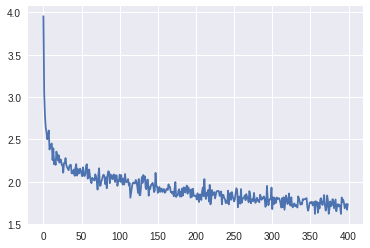

In [55]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Lesson 1.1: Experiment with hyperparameters and optimization

Experiment with the following attributes to improve on the performance of the above model (performance here can only 
be evaluated by looking at how sensible the produced tweets are): 

* Change the ```threshold``` number in the ```sample_prediction``` method above - the higher the less importance to high probabilities will be given, ergo the lower the more important high output probabilities will be
* Experiment with different optimizers (see [PyTorch Optimizers](https://pytorch.org/docs/stable/optim.html))
* Increase the depth of the network (what was the depth again?)
* Experiment with the number of epochs

Once you are done with optimizing the result and hopefully have obtained some nice automatically generated tweets, you can try the generation process on a different corpus. For instance, a Tweet collection of someone else or frequently these types of language models are applied to some Shakespeare corpus, e.g. [this one provided by Andrew Karpathy](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt).
